<a href="https://colab.research.google.com/github/skyMei-J/Spark/blob/main/%EF%BC%ADask_Detect_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%env SPARK_DRIVER_MEMORY=4g

env: SPARK_DRIVER_MEMORY=4g


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

! java -version 2>&1 | awk -F[\"_] 'NR==1{print $2}'

openjdk version "1.8.0_292"
OpenJDK Runtime Environment (build 1.8.0_292-8u292-b10-0ubuntu1~18.04-b10)
OpenJDK 64-Bit Server VM (build 25.292-b10, mixed mode)
1.8.0


In [3]:
%tensorflow_version 1.x
!pip3 uninstall kapre
!pip3 install tensorflow==1.15
!pip3 install analytics-zoo 
!pip3 install numpy==1.18.5

TensorFlow 1.x selected.


In [4]:

from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper librariesf
import numpy as np
import matplotlib.pyplot as plt

# You MUST use tensorflow 1.15
print(tf.__version__)

1.15.0


In [5]:
from PIL import Image, ImageOps
import numpy as np
from os import listdir
from os.path import isfile, isdir, join

In [6]:

Mask_path = "/content/drive/MyDrive/dataset/Mask"
files = listdir(Mask_path)
fullpath = join(Mask_path, files[0])
image = Image.open(fullpath) 
np_arr1 = np.array(image)
width=28
height=28
train_data = np.empty((0,width,height), int)
Mask_len = len(files)
print("Number of data of No_mask:",len(files))
for f in files:

  fullpath = join(Mask_path, f)
  image = Image.open(fullpath)   # image is a PIL image 
  gray = ImageOps.grayscale(image)
  np_arr2 = gray.resize((28,28))
  np_arr3 = np.array(np_arr2)  
  np_arr4 = np.expand_dims(np_arr3, axis=0)
  train_data = np.append(train_data,np_arr4,axis=0)


print("Mask array shape:",train_data.shape)
  

Number of data of No_mask: 113
Mask array shape: (113, 28, 28)


In [7]:
No_mask_path = "/content/drive/MyDrive/dataset/No_mask"
files = listdir(No_mask_path)
fullpath = join(No_mask_path, files[0])
image = Image.open(fullpath) 
np_arr1 = np.array(image)
print("Number of data of Mask:",len(files))
for f in files:

  fullpath = join(No_mask_path, f)
  image = Image.open(fullpath)   # image is a PIL image 
  gray = ImageOps.grayscale(image)
  np_arr2 = gray.resize((28,28))
  np_arr3 = np.array(np_arr2)  
  np_arr4 = np.expand_dims(np_arr3, axis=0)
  train_data = np.append(train_data,np_arr4,axis=0)
print("No_mask array shape:",train_data.shape)


Number of data of Mask: 130
No_mask array shape: (243, 28, 28)


In [8]:
import random
My_list = [*range(0, train_data.shape[0], 1)]#0~242
random.seed('foobar')
Seq = random.sample(My_list,len(My_list))
print("Generate",len(Seq) ," Random Sample")
train_images = np.empty((0,width,height), int)
label = []
count=0
for s in Seq:
  temp = np.expand_dims(train_data[s], axis=0)
  train_images = np.append(train_images,temp,axis=0)
  if s<Mask_len:
    label.append(1)#Mask
  else:
    label.append(0)#No Mask
  #print(s,count,label[count])
  count+=1
  
train_labels = np.array(label)
print("data array shape:",train_images.shape)
print("label array shape:",train_labels.shape)

Generate 243  Random Sample
data array shape: (243, 28, 28)
label array shape: (243,)


In [9]:
class_names = ['No_Mask', 'Mask']

In [10]:
train_images2 = train_images[:100]
train_labels2 = train_labels[:100]

In [11]:
test_images = train_images[200:243]
train_images=train_images[0:200]
test_labels = train_labels[200:243]
train_labels = train_labels[0:200]
print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)
print(test_labels.shape)
print(type(test_labels))

(200, 28, 28)
(43, 28, 28)
(200,)
(43,)
<class 'numpy.ndarray'>


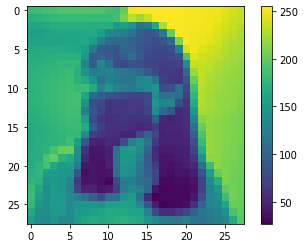

In [12]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [13]:
train_images = train_images / 255.0
train_images2 = train_images2 / 255.0
test_images = test_images / 255.0

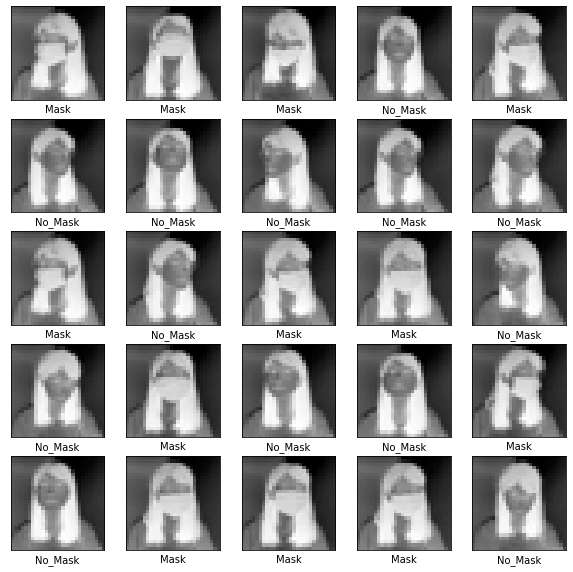

In [14]:

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [15]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(width, height)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [16]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
from zoo.tfpark import KerasModel, TFDataset
from zoo import init_nncontext
# set up enviroment
_ = init_nncontext()
# wrap model as tfpark model for distributted training, evaluation and prediction
model = KerasModel(model)

Prepending /usr/local/lib/python3.7/dist-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
Adding /usr/local/lib/python3.7/dist-packages/zoo/share/lib/analytics-zoo-bigdl_0.12.2-spark_2.4.3-0.10.0-jar-with-dependencies.jar to BIGDL_JARS
Prepending /usr/local/lib/python3.7/dist-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path

pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.7/dist-packages/zoo/share/lib/analytics-zoo-bigdl_0.12.2-spark_2.4.3-0.10.0-jar-with-dependencies.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/lib/bigdl-0.12.2-jar-with-dependencies.jar pyspark-shell 


In [18]:
MODEL_PATH = "/content/drive/MyDrive/dataset/model/model.pb"
dataset = TFDataset.from_ndarrays((train_images, train_labels),
                                 batch_size=160,
                                 val_tensors=(test_images, test_labels))
model.fit(dataset, epochs=100, batch_size=160)
model.save_model(MODEL_PATH)
print("Save model, Path:",MODEL_PATH)





creating: createTFParkSampleToMiniBatch
creating: createZooKerasSparseCategoricalCrossEntropy
creating: createLoss
creating: createZooKerasSparseCategoricalAccuracy
creating: createFakeOptimMethod
Instructions for updating:
Use `tf.cast` instead.

creating: createTFValidationMethod
creating: createTFValidationMethod





creating: createTFTrainingHelper
creating: createIdentityCriterion
creating: createTFParkSampleToMiniBatch
creating: createTFParkSampleToMiniBatch
creating: createEstimator
creating: createMaxEpoch
creating: createEveryEpoch
INFO:tensorflow:Restoring parameters from /tmp/tmpscy_xysh/model
Save model, Path: /content/drive/MyDrive/dataset/model/model.pb


In [19]:
eval_dist = model.evaluate(test_images, test_labels, batch_per_thread=280, distributed=True)
print(eval_dist)
print('Test accuracy:', eval_dist['acc Top1Accuracy'])


creating: createZooKerasAccuracy
creating: createStatelessMetric
creating: createTFValidationMethod
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'TFNdarrayDataset' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'TFNdarrayDataset' object has no attribute 'name'
INFO:tensorflow:SavedModel written to: /tmp/tmpmkfiiaaw/saved_model.pb
{'loss': 0.009915508329868317, '

In [20]:
predictions = model.predict(test_images, batch_per_thread=280, distributed=True)

INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'TFNdarrayDataset' object has no attribute 'name'
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'TFNdarrayDataset' object has no attribute 'name'
INFO:tensorflow:SavedModel written to: /tmp/tmpngcierwl/saved_model.pb


In [21]:
predictions[0]

array([0.04090997, 0.95909005], dtype=float32)

In [22]:
np.argmax(predictions[0])

1

In [23]:
test_labels[0]

1

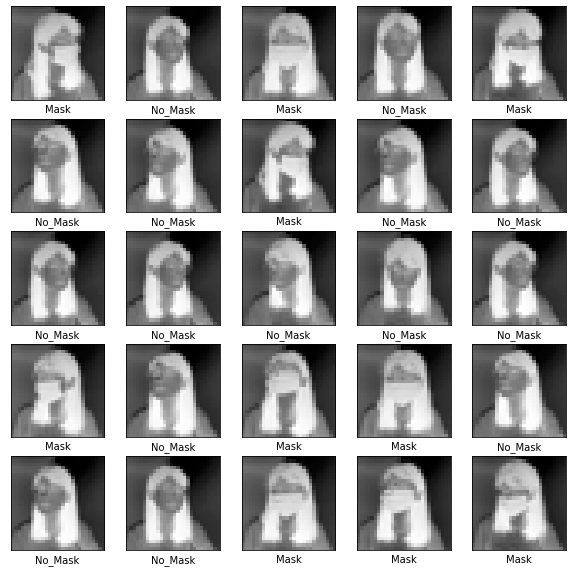

In [24]:

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[np.argmax(predictions[i])])
plt.show()

In [25]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [26]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [27]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [28]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [29]:
inference_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(width, height)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])
inference_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# set up enviroment
_ = init_nncontext()
# wrap model as tfpark model for distributted training, evaluation and prediction
inference_model = KerasModel(inference_model)

In [30]:
#/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/keras/saving/hdf5_format.py 
#remove line 160: .decode('utf-8')
from zoo.tfpark import KerasModel
inference_model = model.load_model(MODEL_PATH)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [32]:

from PIL import Image, ImageOps
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    
    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    crop = gray[:,80:560]
    np_arr2 = cv2.resize(crop, (28,28), interpolation=cv2.INTER_CUBIC)
    np_arr4 = np.expand_dims(np_arr2, axis=0)
    np_arr5 = np_arr4/255.0
    predictions = inference_model.predict(np_arr5, batch_per_thread=280)
    # print(predictions)
    # plt.figure()
    # plt.imshow(crop)
    # plt.colorbar()
    # plt.grid(False)
    # plt.show()

    faces = face_cascade.detectMultiScale(gray)
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    if np.argmax(predictions)==0:
      text='No Mask!'
      cv2.putText(bbox_array, text, (60, 70), cv2.FONT_HERSHEY_SIMPLEX,3, (255, 0, 0), 3, cv2.LINE_AA)
    else:
      text='Mask!'
      cv2.putText(bbox_array, text, (60, 70), cv2.FONT_HERSHEY_SIMPLEX,3, (0, 255, 255), 3, cv2.LINE_AA)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes
    

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored